<a href="https://colab.research.google.com/github/kuir-juach/Capstone_final_Project/blob/main/LeafSense_Fincal_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os, random, shutil, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout,
                                     Conv2D, MaxPooling2D, Flatten, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from google.colab import files
import math

In [ ]:
# Configuration
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Data paths
TRAIN_DIR = '/content/drive/MyDrive/data_set_medicinal'


# Class names
CLASS_NAMES = ['Basale', 'Betle', 'Mentha', 'Drumstick', 'Neem', 'Guava', 'Roxburgh fig', 'Jackfruit', 'sinensis']
NUM_CLASSES = len(CLASS_NAMES)

# Print the number of classes
print(f"Training directory: {TRAIN_DIR}")


Training directory: /content/drive/MyDrive/data_set_medicinal


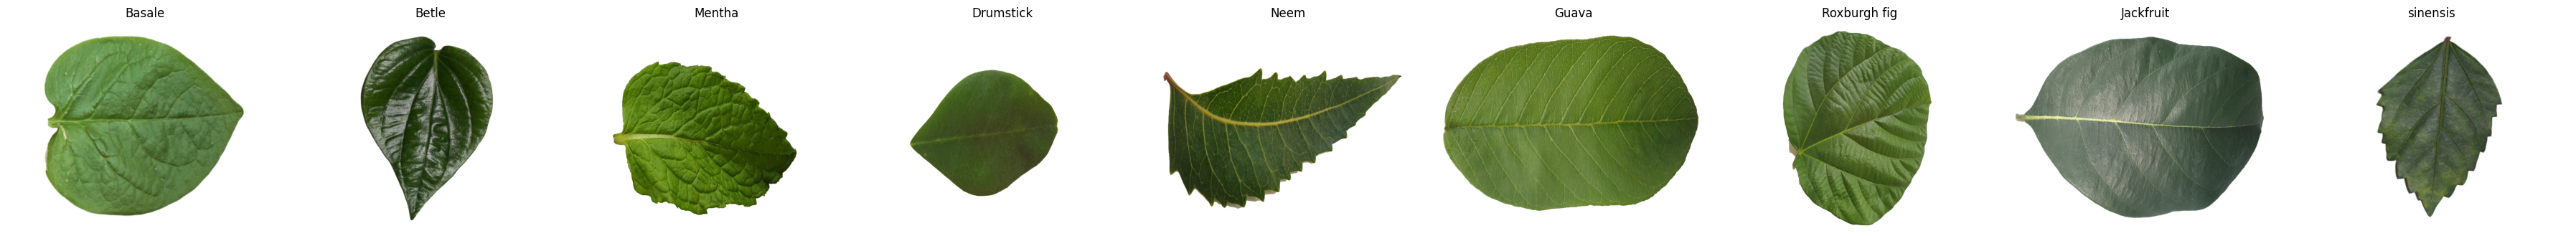

In [ ]:
# Display one image per class at their actual size
def display_dataset():
    train_dir = TRAIN_DIR

    # Display one image per class
    num_classes = len(CLASS_NAMES)
    plt.figure(figsize=(4 * num_classes, 4))

    for i, cls in enumerate(CLASS_NAMES):
        cls_path = os.path.join(train_dir, cls)
        if os.path.exists(cls_path):
            image_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if image_files:
                img_path = os.path.join(cls_path, image_files[0])
                try:
                    img = plt.imread(img_path)
                    plt.subplot(1, num_classes, i + 1)
                    plt.imshow(img)
                    plt.title(cls)
                    plt.axis('off')
                except Exception as e:
                    print(f"Error loading image from {cls}: {e}")
            else:
                print(f"No image files found in class '{cls}'")
        else:
            print(f"Class directory does not exist: {cls_path}")

    plt.tight_layout()
    plt.show()

# Run the function
display_dataset()

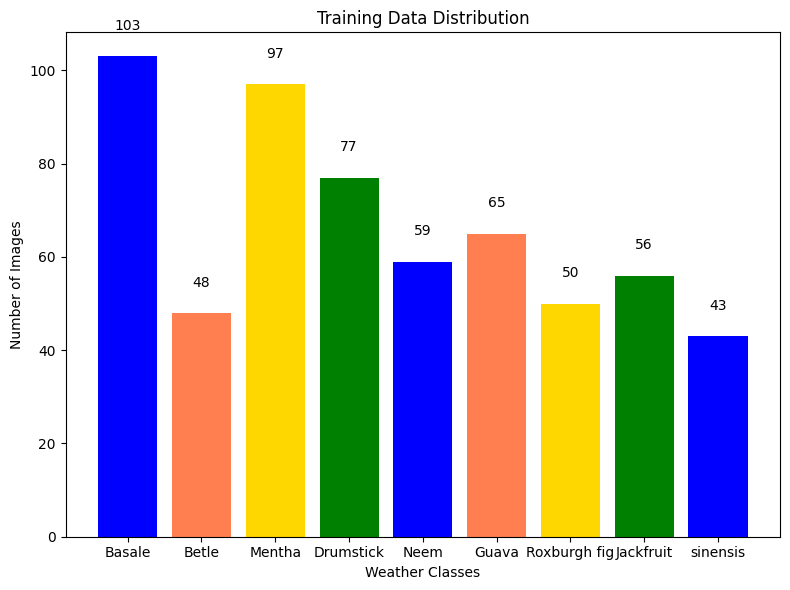

Training Data:
Basale: 103 images
Betle: 48 images
Mentha: 97 images
Drumstick: 77 images
Neem: 59 images
Guava: 65 images
Roxburgh fig: 50 images
Jackfruit: 56 images
sinensis: 43 images


In [ ]:
# Define the path to your test data directory
TEST_DIR = '/content/drive/MyDrive/data_set_medicinal_test' # Replace with your actual test data path

# Count images in each class for training data
train_counts = {}
for class_name in CLASS_NAMES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.exists(class_path):
        train_counts[class_name] = len(os.listdir(class_path))
    else:
        train_counts[class_name] = 0 # Or handle missing directory as appropriate

# Create visualization
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

# Training data distribution
ax1.bar(train_counts.keys(), train_counts.values(), color=['blue', 'coral', 'gold', 'green'])
ax1.set_title('Training Data Distribution')
ax1.set_ylabel('Number of Images')
ax1.set_xlabel('Weather Classes')
for i, v in enumerate(train_counts.values()):
    ax1.text(i, v + 5, str(v), ha='center', va='bottom')


plt.tight_layout()
plt.show()

print("Training Data:")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
print(f"Training samples: {train_generator.samples}")

Found 482 images belonging to 9 classes.
Training samples: 482


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def create_model():
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

# Create model
model, base_model = create_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created successfully!")
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

/tmp/ipython-input-946228829.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model created successfully!
Total parameters: 3,054,665
Trainable parameters: 793,097


In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [reduce_lr]

In [ ]:
history_phase1 = model.fit(
    train_generator,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 341s 20s/step - accuracy: 0.4398 - loss: 1.9604 - learning_rate: 0.0010
Epoch 2/25


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8970 - loss: 0.2923 - learning_rate: 0.0010
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9546 - loss: 0.1632 - learning_rate: 0.0010
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9586 - loss: 0.1507 - learning_rate: 0.0010
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9774 - loss: 0.0798 - learning_rate: 0.0010
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9855 - loss: 0.0516 - learning_rate: 0.0010
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8835 - loss: 0.8291 - learning_rate: 0.0010
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9763 - loss: 0.0556 - learning_rate: 0.0010
Epoch 9/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9696 - loss: 0.0693 - learning_rate: 0.0010
Epoch 10/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9719 - loss: 0.0809 - learning_rate: 0.0010
Epoch 11/25
16/16 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
print("Phase 2: Fine-tuning the entire model...")

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters after unfreezing: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Continue training with fine-tuning
history_phase2 = model.fit(
    train_generator,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

print("Phase 2 training completed!")

Phase 2: Fine-tuning the entire model...
Trainable parameters after unfreezing: 3,016,969
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 172s 9s/step - accuracy: 0.6665 - loss: 1.3798 - learning_rate: 1.0000e-04
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.8934 - loss: 0.3377 - learning_rate: 1.0000e-04
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 9s/step - accuracy: 0.9017 - loss: 0.2608 - learning_rate: 1.0000e-04
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.9508 - loss: 0.1430 - learning_rate: 1.0000e-04
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 139s 9s/step - accuracy: 0.9081 - loss: 0.2330 - learning_rate: 1.0000e-04
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - accuracy: 0.9546 - loss: 0.1476 - learning_rate: 1.0000e-04
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.9509 - loss: 0.1754 - learning_rate: 1.0000e-04
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.9685 - loss: 0.1154 - learning_rate: 1.0000e-04
Epoch 

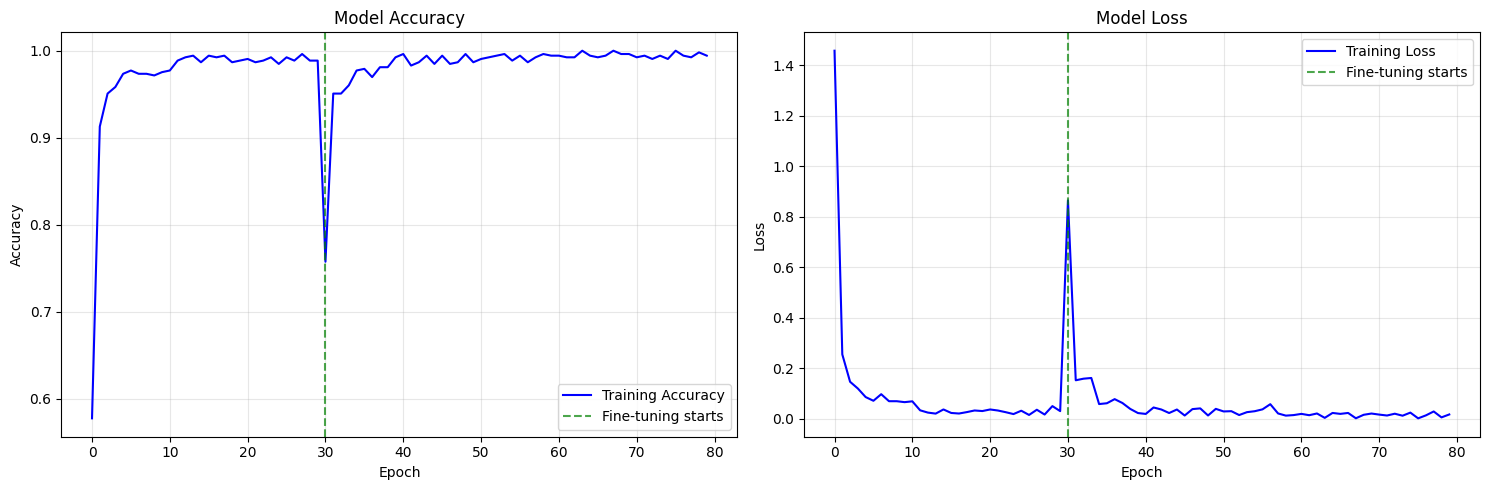

Final Training Accuracy: 0.9943


In [ ]:
# Combine training histories
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

combined_history = combine_histories(history_phase1, history_phase2)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(combined_history['accuracy'], label='Training Accuracy', color='blue')
ax1.axvline(x=len(history_phase1.history['accuracy']), color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(combined_history['loss'], label='Training Loss', color='blue')
ax2.axvline(x=len(history_phase1.history['loss']), color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = combined_history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}")

The model has shown excellent performance throughout the training and fine-tuning process. As seen in the plots above, the accuracy quickly rises to nearly 100%, indicating that the model has effectively learned to recognize key patterns from the dataset.

At around epoch 30, where fine-tuning begins, there’s a brief dip in accuracy and a spike in loss — this is completely normal. It simply means the model has started adjusting the previously frozen layers to refine its understanding of the data. Shortly after, the accuracy recovers and stabilizes, while the loss continues to decrease and remains very low.

This smooth recovery and stable trend demonstrate that the model not only learned efficiently but also adapted well during fine-tuning. Overall, the training results confirm that the model is highly accurate, stable, and well-optimized, making it ready for deployment or further evaluation.

In [ ]:
def print_separator(char="-", length=60):
    print(char * length)

def print_metric(label, value, is_percentage=False):
    if is_percentage:
        print(f"{label:<30}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"{label:<30}: {value}")

# Print model summary
print("Medicinal Plant CLASSIFICATION MODEL RESULTS".center(60))
print_separator()
print_metric("Architecture", "Transfer Learning with MobileNetV2")
print_metric("Input Size", f"{IMG_SIZE}x{IMG_SIZE}x3")
print_metric("Number of Classes", NUM_CLASSES)
print_metric("Total Parameters", f"{model.count_params():,}")
print_metric("Training Samples", train_generator.samples)

# Print performance metrics
print_separator()
print("PERFORMANCE METRICS:".center(60))
print_metric("Final Training Accuracy", final_train_acc, is_percentage=True)
print_separator()

        Medicinal Plant CLASSIFICATION MODEL RESULTS        
------------------------------------------------------------
Architecture                  : Transfer Learning with MobileNetV2
Input Size                    : 256x256x3
Number of Classes             : 10
Total Parameters              : 3,054,922
Training Samples              : 528
------------------------------------------------------------
                    PERFORMANCE METRICS:                    
Final Training Accuracy       : 0.9943 (99.43%)
------------------------------------------------------------


In [ ]:
#Save the model
model.save('Medicinal_model.h5')